<a href="https://colab.research.google.com/github/ramandrosoa/github_test/blob/main/Deep_Learning_with_PyTorch_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCAM - Gradient Class Activation Map

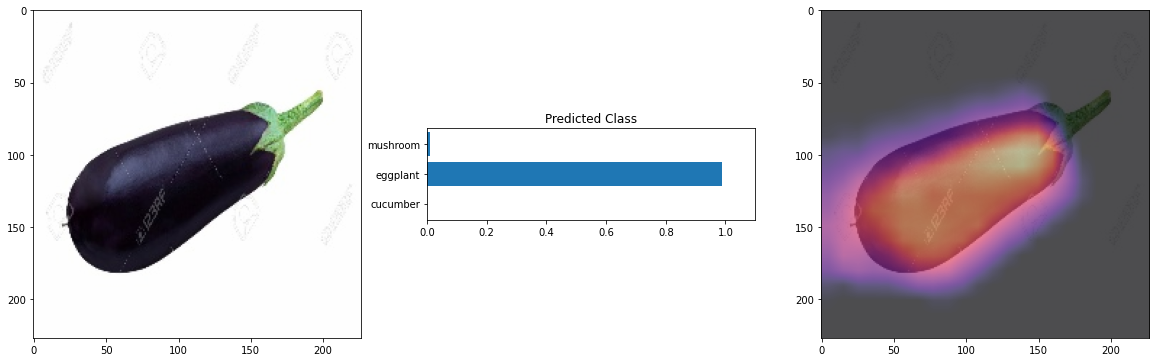

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 14.09 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-6rfvxomo
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-6rfvxomo
  Resolved https://github.com/albumentations-team/albumentations to commit d40477d5643e5031278312cfe924d241b3ae3afd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/

# Imports

In [2]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [6]:
csv_file  ="/content/GradCAM-Dataset/train.csv"
data_dir = "/content/GradCAM-Dataset/"

device = "cuda" #GPU
batch_size =16
learning_rate = 0.001
epochs  =20

In [7]:
data = pd.read_csv(csv_file)

data.head()

#labels are given in a numerical format
#0 : cucumber
#1 : eggplant
#2 : mushroom

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [8]:
train_df, valid_df = train_test_split(data, test_size =0.2, random_state=42)

# Augmentations

In [10]:
  #Augmentation for train and valid dataset
  #library : albumentation (Pytorch)

train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])  #From ImageNet

valid_augs = A.Compose([
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

]) #From ImageNet

# Load Image Dataset

In [11]:
  #Apply the augmentation on the dataset

trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir = data_dir)
validset = utils.ImageDataset(valid_df, augs = valid_augs, data_dir = data_dir)

Text(0.5, 1.0, 'cucumber')

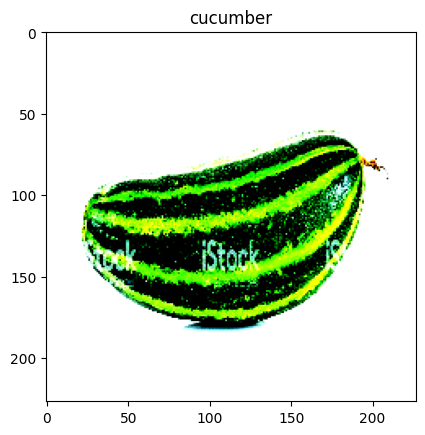

In [20]:
image, label  = validset[22] #(channel, height, width) -> (height, width, channel)

class_list = ["cucumber","eggplant", "mushroom"]

plt.imshow(image.permute(1,2,0)) #height =1 , width =2, channel =0
plt.title(class_list[label])


In [18]:
print(f"No. of examples in the trainset {len(trainset)}")
print(f"No. of examples in the  validset {len(validset)}")

No. of examples in the trainset 148
No. of examples in the  validset 38


# Load Dataset into Batches

In [21]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(validset, batch_size = batch_size, shuffle = False)

In [22]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [23]:
for images, labels in trainloader:
  break

print(f"One batch image shape : {images.shape}") #(batch_size, channel, height, width)
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


There are 16 images in 1 batch and each image has channel 3, height 227 and width 227

# Create Model

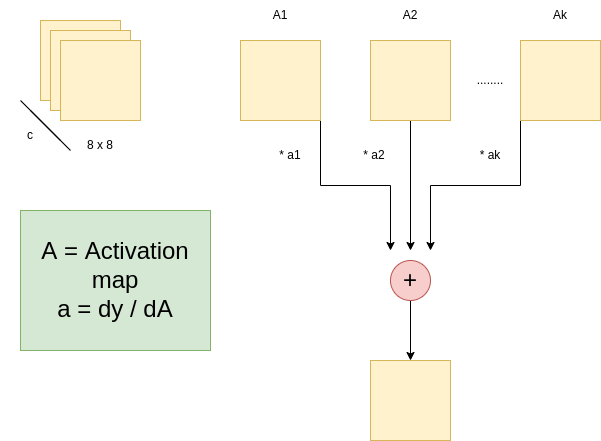

In [34]:
  #create the model
class ImageModel(nn.Module):

    def __init__(self):
        super(ImageModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (5,5), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),

            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (5,5), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),

            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (5,5), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),

            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (5,5), padding = 1),
            nn.ReLU(),

        )
        self.maxpool = nn.MaxPool2d(kernel_size = (4,4), stride = 2)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Linear(2048,3))

        self.gradient = None

    def activations_hook(self, grad):
        self.gradient = grad



    def forward(self, images):
        x = self.feature_extractor(images)#activation maps
        h = x.register_hook(self.activations_hook)  #get the gradients
        x = self.maxpool(x)
        x = self.classifier(x)
        return x

    def get_activation_gradients(self): #a1,a2, ... ak
        return self.gradient

    def get_activation(self, x): #A1,A2,...AK
        return self.feature_extractor(x)

In [30]:
model = ImageModel()
model.to(device)  #GPU

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [57]:
def eval_fn(dataloader, model, criterion): #criterion : loss function
    model.eval()
    total_loss = 0.0
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)


        logits = model(images)  #Loss : crossentropy , inputs are logits
        loss = criterion(logits, labels)


        total_loss += loss.item()

    return total_loss / len(dataloader)

In [58]:
def train_fn(dataloader, model, optimizer, criterion): #criterion : loss function
    model.eval()
    total_loss = 0.0
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()


        logits = model(images)  #Loss : crossentropy , inputs are logits
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Training Loop

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [60]:
best_valid_loss = np.Inf

for i in range(epochs):

  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss < best_valid_loss:
      torch.save(model.state_dict(), "best_weights.pt")

      best_valid_loss = valid_loss
      print("Saved weights success")

  print(f"Epoch{i+1} Train Loss :{train_loss} Valid Loss:{valid_loss}")


100%|██████████| 3/3 [00:00<00:00, 28.20it/s]


Saved weights success
Epoch1 Train Loss :0.7403349831700325 Valid Loss:1.1204695602258046


100%|██████████| 3/3 [00:00<00:00, 36.22it/s]


Saved weights success
Epoch2 Train Loss :0.4981380611658096 Valid Loss:0.5441471636295319


100%|██████████| 3/3 [00:00<00:00, 34.74it/s]


Saved weights success
Epoch3 Train Loss :0.4532882336527109 Valid Loss:0.2064149243136247


100%|██████████| 3/3 [00:00<00:00, 32.26it/s]


Epoch4 Train Loss :0.41700711026787757 Valid Loss:0.2390987053513527


100%|██████████| 3/3 [00:00<00:00, 36.10it/s]


Epoch5 Train Loss :0.45832094699144366 Valid Loss:0.24019103745619455


100%|██████████| 3/3 [00:00<00:00, 34.96it/s]


Epoch6 Train Loss :0.3203458458185196 Valid Loss:0.2711155650516351


100%|██████████| 3/3 [00:00<00:00, 34.83it/s]


Saved weights success
Epoch7 Train Loss :0.18446930907084608 Valid Loss:0.10931670091425379


100%|██████████| 3/3 [00:00<00:00, 39.27it/s]


Epoch8 Train Loss :0.0816345727071166 Valid Loss:0.38782060146331787


100%|██████████| 3/3 [00:00<00:00, 42.98it/s]


Saved weights success
Epoch9 Train Loss :0.10589824132621288 Valid Loss:0.03669494390487671


100%|██████████| 3/3 [00:00<00:00, 46.69it/s]


Epoch10 Train Loss :0.07936927045229822 Valid Loss:0.383401566495498


100%|██████████| 3/3 [00:00<00:00, 44.03it/s]


Epoch11 Train Loss :0.14184516738168895 Valid Loss:0.10084044933319092


100%|██████████| 3/3 [00:00<00:00, 46.20it/s]


Epoch12 Train Loss :0.14226934968028218 Valid Loss:0.6001432612538338


100%|██████████| 3/3 [00:00<00:00, 45.32it/s]


Epoch13 Train Loss :0.14653022908605634 Valid Loss:0.19108051620423794


100%|██████████| 3/3 [00:00<00:00, 47.14it/s]


Epoch14 Train Loss :0.16330830077640712 Valid Loss:0.538932611544927


100%|██████████| 3/3 [00:00<00:00, 46.78it/s]


Epoch15 Train Loss :0.14165399670600892 Valid Loss:0.05350692380064478


100%|██████████| 3/3 [00:00<00:00, 46.61it/s]


Epoch16 Train Loss :0.0285363431670703 Valid Loss:0.32000417181795154


100%|██████████| 3/3 [00:00<00:00, 47.16it/s]


Epoch17 Train Loss :0.031205980858521797 Valid Loss:0.3197227743609498


100%|██████████| 3/3 [00:00<00:00, 47.85it/s]


Epoch18 Train Loss :0.03969056793866912 Valid Loss:0.6452973162862085


100%|██████████| 3/3 [00:00<00:00, 46.86it/s]


Epoch19 Train Loss :0.009121868119109422 Valid Loss:0.2482111189098267


100%|██████████| 3/3 [00:00<00:00, 48.43it/s]

Epoch20 Train Loss :0.002300194472820749 Valid Loss:0.31592118408917713


# Get GradCAM

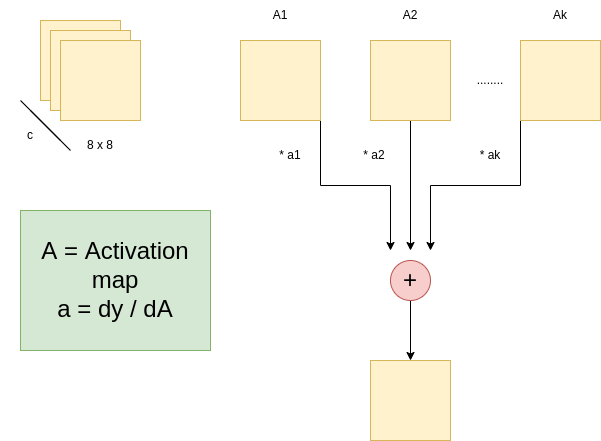

In [68]:
def get_grad_cam(model, image, label, size):

    label.backward()
    gradients = model.get_activation_gradients()
    pooled_gradients = torch.mean(gradients, dim= [0, 2, 3]) #Number of rates depends on channels (a1, a2...)
    activations = model.get_activation(image).detach() #A1, A2 ... Ak

    for i in range(activations.shape[1]):
        activations[:,i,:,:]*= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap /= torch.max(heatmap)

    heatmap  = cv2.resize(heatmap.numpy(), (size,size))

    return heatmap

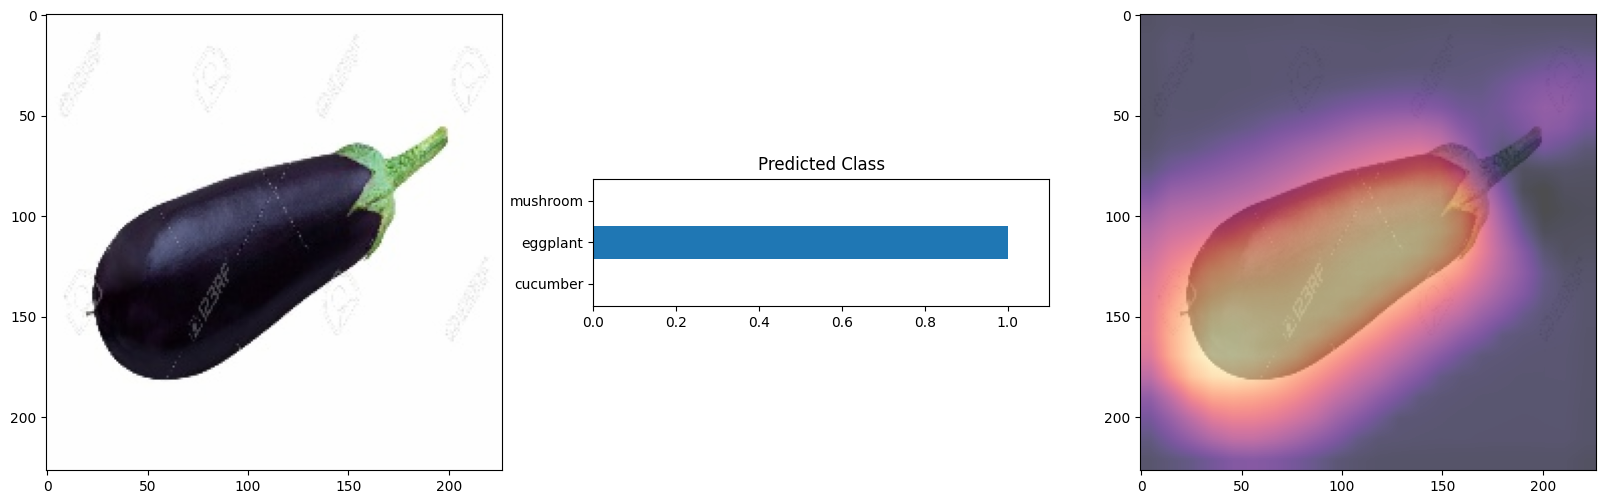

In [73]:
image,label = validset[4]

denorm_image = image.permute(1, 2, 0)*np.array((0.229, 0.224, 0.225))+np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(device)

pred = model(image)

heatmap = get_grad_cam(model, image, pred[0][1], size = 227)  #0: cucumber, 1:eggplant, 2:mushroom

utils.plot_heatmap(denorm_image, pred, heatmap)




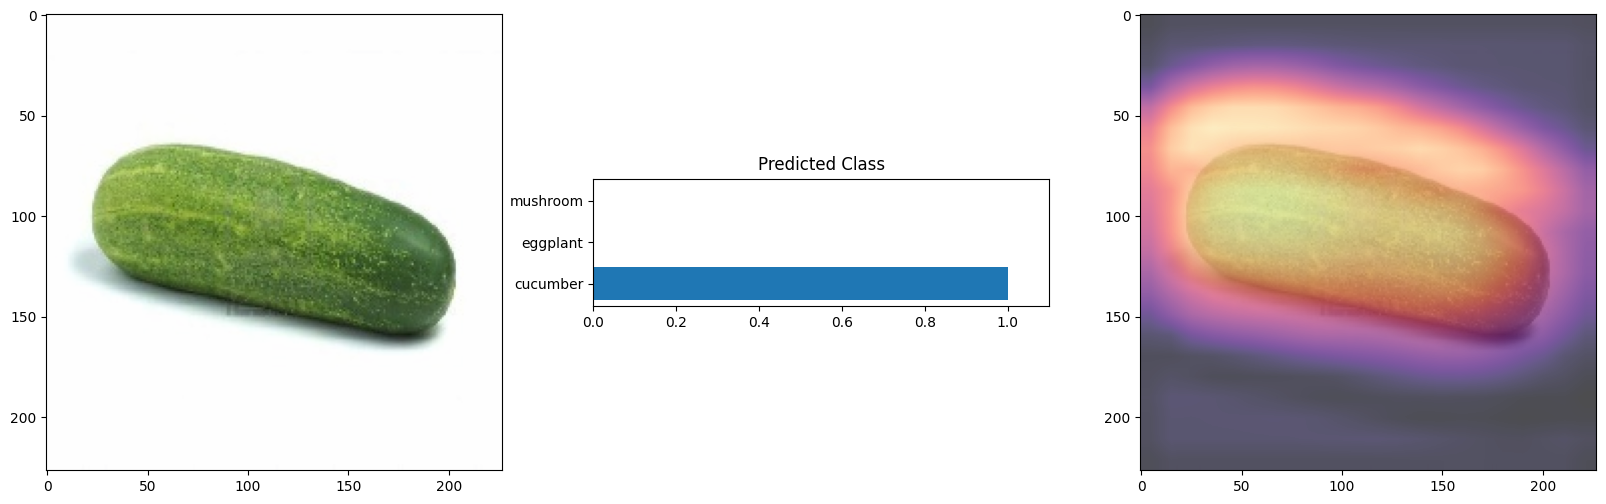

In [78]:
image,label = validset[7]

denorm_image = image.permute(1, 2, 0)*np.array((0.229, 0.224, 0.225))+np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(device)

pred = model(image)

heatmap = get_grad_cam(model, image, pred[0][0], size = 227)  #0: cucumber, 1:eggplant, 2:mushroom

utils.plot_heatmap(denorm_image, pred, heatmap)


